In [ ]:
using Revise

In [211]:
using ForwardDiff
using Plots
using LinearAlgebra
using BenchmarkTools
using QuadGK

In [169]:
include("src/projection.jl")
include("src/interpolation.jl")


create_nodes_chebyshev

In [1]:
include("src/Reparam.jl")

┌ Warning: Replacing docs for `Main.Reparam.pointwise_distance :: Tuple{Any,Any}` in module `Main.Reparam`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `Main.Reparam.pointwise_product :: Tuple{Any,Any}` in module `Main.Reparam`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `Main.Reparam.pointwise_square :: Tuple{Any}` in module `Main.Reparam`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `Main.Reparam.integrate :: Tuple{Any,Vararg{Any,N} where N}` in module `Main.Reparam`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `Main.Reparam.quadgk_adaptive :: Tuple{Any}` in module `Main.Reparam`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `Main.Reparam.l2_norm :: Tuple{Any}` in module `Main.Reparam`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `Main.Reparam.l2_distance :: Tuple{Any,Any}` in module `Main.Reparam`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `Main.Reparam.l2_inner_product 

l2_gradient (generic function with 1 method)

In [2]:
module Dev
using LinearAlgebra
using QuadGK
using ForwardDiff
using SpecialFunctions: gamma

include("src/functionals.jl")
abstract type BasisFunction end

struct BasisExpansion{TF <: Real, TB <: BasisFunction}
    W::Vector{TF}
    B::Vector{TB}
    dim::Int
    
    function BasisExpansion(W::Vector{TF}, B::Vector{TB}) where {TF <: Real, TB <: BasisFunction}
        @assert length(W) == length(B) "Weights and Basis should be of same length"
        new{TF, TB}(W, B, length(W))
    end
end

function (BE::BasisExpansion)(x)
    out = 0.0
    for i in 1:BE.dim
        out += BE.W[i] * BE.B[i](x)
    end
    return out
end


struct GaussianRadialBasisFunction{T<:Real} <: BasisFunction
    center::T
    param::T
end

# Alternate constructor with promotion
GaussianRadialBasisFunction(c, p) = GaussianRadialBasisFunction(promote(c, p)...)

""" Function evaluation of a gaussian radial basis function """
function (g::GaussianRadialBasisFunction)(x)
    return exp(-(g.param * (x - g.center))^2)
end


function GaussianRadialBasis(N::Int; param=nothing)
    if param === nothing
        param = convert(Float64, N-1)
    end
    X = range(0, 1, length=N)
    return [GaussianRadialBasisFunction(xi, param) for xi in X]
end


struct FourierSineBasisFunction <: BasisFunction
    n::Int
end

function (f::FourierSineBasisFunction)(x)
    return √2 * sin(π * f.n * x)
end

FourierSineBasis(N::Int) = [FourierSineBasisFunction(n) for n in 1:N]


struct PalaisBasisFunction <: BasisFunction
    n::Int
    label::String
    
    function PalaisBasisFunction(m::Int, label::String)
        @assert label in ["cos", "sin"] "label must be of type 'sin' or 'cos'."
        new(m, label)
    end
end

# Alternative constructor with single argument, choosing type based on odd/even
function PalaisBasisFunction(n::Int) 
    n % 2 == 0 ? PalaisBasisFunction(n ÷ 2, "sin") : PalaisBasisFunction(n ÷ 2 + 1, "cos")
end

PalaisBasis(N::Int) = [PalaisBasisFunction(n) for n in 1:N]

""" Function Evaluation of PalaisBasisFunction """
function (p::PalaisBasisFunction)(x)
    if p.label == "sin"
        return sin(2π * p.n * x) / (√2 * π * p.n)
    end
    return (cos(2π * p.n * x) - 1) / (√2 * π * p.n)
end


""" Function to compute the normalizing constant of the n-th 
Jacobi-based polynomial"""
function C(n)
    return (2^5 / (2n+5))  * (gamma(n+3) * gamma(n+3)) / (32 * gamma(n+5) * factorial(big(n)))
end


""" Function to compute the coefficients of the n-th 
Jacobi-based polynomial"""
function B(n)
    return [gamma(n+3) * binomial(n, m) * gamma(n+m+5) / (factorial(big(n)) * gamma(n+5) * gamma(m+3)) for m in 0:n]
end


"""Construct the n-th jacobi-based polynomial. Note that 
the degree of the polynomial is 2 larger than n, n<2.
"""
function jacobi_polynomial(n)
    # Compute Coefficients in the jacobi polynomial
    Cn = C(n)
    Bn = [Float64(bi / sqrt(Cn)) for bi in B(n)]
    
    # Create function
    function (x)
        out = 0.0
        for m in 0:n
            out += Bn[m+1] * (x-1)^m
        end
        return out * x * (1-x)
    end
end

struct JacobiBasisFunction <: BasisFunction
    C::Vector{Float64}
    n::Int
    
    function JacobiBasisFunction(n)
        # Compute Coefficients in the jacobi polynomial
        Cn = C(n)
        Bn = [Float64(bi / sqrt(Cn)) for bi in B(n)]
        return new(Bn, n)
    end
end

function (J::JacobiBasisFunction)(x)
    out = 0.0
    for m in 0:J.n
        out += J.C[m+1] * (x-1)^m
    end
    return out * x * (1-x)
end

JacobiBasis(N::Int) = [JacobiBasisFunction(n) for n in 0:N-1]



struct OrthogonalProjector{T <: BasisFunction, F <: Function}
    basis::Vector{T}
    inner_product::F
end

struct InterpolationProjector{T <: BasisFunction, TF <: Real}
    basis::Vector{T}
    mass_matrix::Matrix{TF}
    dim::Int
    
    function InterpolationProjector(basis::Vector{T}) where {T <: BasisFunction}
        A = [bi(bj.center) for bj in basis, bi in basis]
        new{T, typeof(A[1, 1])}(basis, A, length(basis))
    end
end

function GaussianInterpolationProjector(N::Int; param=nothing)
    @assert N > 2 "Need at least 3 basis function for interpolation."
    basis = GaussianRadialBasis(N, param=param)
    return InterpolationProjector(basis)
end
    

FourierSineProjector(N::Int) = OrthogonalProjector(FourierSineBasis(N), l2_inner_product)
PalaisProjector(N::Int) = OrthogonalProjector(PalaisBasis(N), palais_inner_product)
JacobiProjector(N::Int) = OrthogonalProjector(JacobiBasis(N), l2_inner_product)


function project(f, OP::OrthogonalProjector)
    W = [OP.inner_product(f, bi) for bi in OP.basis]
    return BasisExpansion(W, OP.basis)
end


function project(f, IP::InterpolationProjector)
    b = load_vector(f, [bi.center for bi in IP.basis])
    W = IP.mass_matrix \ b
    return BasisExpansion(W, IP.basis)
end


""" Create the interpolation load vector, which should be the function values on internal nodes, and zero
on the boundaries."""
function load_vector(f, nodes)
    b = zeros(length(nodes))
    b[2:end-1] = [f(xi) for xi in nodes[2:end-1]]
    return b
end
end #module 

Main.Dev

In [205]:
r = Dev.GaussianRadialBasisFunction(0.5, 0.5)
f = Dev.FourierSineBasisFunction(1)
g = Dev.PalaisBasisFunction(2)
j = Dev.JacobiBasisFunction(1)

@code_warntype r(0.1)
@code_warntype f(0.1)
@code_warntype g(0.1)
@code_warntype j(0.1)

@time r(0.1)
@time f(0.1)
@time g(0.1)
@time j(0.1)

Variables
  g::Main.Dev.GaussianRadialBasisFunction{Float64}
  x::Float64

Body::Float64
1 ─ %1 = Base.getproperty(g, :param)::Float64
│   %2 = Base.getproperty(g, :center)::Float64
│   %3 = (x - %2)::Float64
│   %4 = (%1 * %3)::Float64
│   %5 = Core.apply_type(Base.Val, 2)::Core.Compiler.Const(Val{2}, false)
│   %6 = (%5)()::Core.Compiler.Const(Val{2}(), false)
│   %7 = Base.literal_pow(Main.Dev.:^, %4, %6)::Float64
│   %8 = -%7::Float64
│   %9 = Main.Dev.exp(%8)::Float64
└──      return %9
Variables
  f::Main.Dev.FourierSineBasisFunction
  x::Float64

Body::Float64
1 ─ %1 = √2::Float64
│   %2 = Base.getproperty(f, :n)::Int64
│   %3 = (Main.Dev.π * %2 * x)::Float64
│   %4 = Main.Dev.sin(%3)::Float64
│   %5 = (%1 * %4)::Float64
└──      return %5
Variables
  p::Main.Dev.PalaisBasisFunction
  x::Float64

Body::Float64
1 ─ %1  = Base.getproperty(p, :label)::String
│   %2  = (%1 == "sin")::Bool
└──       goto #3 if not %2
2 ─ %4  = (2 * Main.Dev.π)::Core.Compiler.Const(6.283185307179586, 

-1.0433791257256397

In [206]:
r = Dev.GaussianRadialBasisFunction(0.5, 0.5)
f = Dev.FourierSineBasisFunction(1)
g = Dev.PalaisBasisFunction(2)
j = Dev.JacobiBasisFunction(1)

Main.Dev.JacobiBasisFunction([14.49137674618944, 28.98275349237888], 1)

In [221]:
N = 1000
weights = rand(N)

rbasis = Dev.GaussianRadialBasis(N)
fbasis = Dev.FourierSineBasis(N)
gbasis = Dev.PalaisBasis(N)
# jbasis = Dev.JacobiBasis(N)

rexp = Dev.BasisExpansion(weights, rbasis)
fexp = Dev.BasisExpansion(weights, fbasis)
gexp = Dev.BasisExpansion(weights, gbasis)
# jexp = Dev.BasisExpansion(W, jbasis)

# @code_warntype rexp(0.1)
# @code_warntype fexp(0.1)
# @code_warntype gexp(0.1)
# @code_warntype jexp(0.1)

@time rexp(0.1)
@time fexp(0.1)
@time gexp(0.1)
@time jexp(0.1)

  0.009985 seconds (22.66 k allocations: 1.256 MiB)
  0.009788 seconds (24.82 k allocations: 1.401 MiB)
  0.014889 seconds (35.20 k allocations: 1.978 MiB)
  0.000003 seconds (1 allocation: 16 bytes)


-3.106160224365447e-15

In [222]:
X = 0:0.01:1
N = 10

F(x) = 1 + x - x^2


rprojector = Dev.GaussianInterpolationProjector(N)
fprojector = Dev.FourierSineProjector(N)
gprojector = Dev.PalaisProjector(N)
jprojector = Dev.JacobiProjector(N)


rproj = Dev.project(F, rprojector)
fproj = Dev.project(F, fprojector)
gproj = Dev.project(F, gprojector)
jproj = Dev.project(F, jprojector);

In [223]:
@code_warntype Dev.project(F, rprojector)
@code_warntype Dev.project(F, fprojector)
@code_warntype Dev.project(F, gprojector)
@code_warntype Dev.project(F, jprojector)

Variables
  #self#::Core.Compiler.Const(Main.Dev.project, false)
  f::Core.Compiler.Const(F, false)
  IP::Main.Dev.InterpolationProjector{Main.Dev.GaussianRadialBasisFunction{Float64},Float64}
  #30::Main.Dev.var"#30#31"
  b::Array{Float64,1}
  W::Array{Float64,1}

Body::Main.Dev.BasisExpansion{Float64,Main.Dev.GaussianRadialBasisFunction{Float64}}
1 ─       (#30 = %new(Main.Dev.:(var"#30#31")))
│   %2  = #30::Core.Compiler.Const(Main.Dev.var"#30#31"(), false)
│   %3  = Base.getproperty(IP, :basis)::Array{Main.Dev.GaussianRadialBasisFunction{Float64},1}
│   %4  = Base.Generator(%2, %3)::Base.Generator{Array{Main.Dev.GaussianRadialBasisFunction{Float64},1},Main.Dev.var"#30#31"}
│   %5  = Base.collect(%4)::Array{Float64,1}
│         (b = Main.Dev.load_vector(f, %5))
│   %7  = Base.getproperty(IP, :mass_matrix)::Array{Float64,2}
│         (W = %7 \ b)
│   %9  = W::Array{Float64,1}
│   %10 = Base.getproperty(IP, :basis)::Array{Main.Dev.GaussianRadialBasisFunction{Float64},1}
│   %11 = Main

In [228]:
@time begin
    basis = basis_fourier_sine(N)
    proj = project(F, basis)
end

  1.302860 seconds (26.67 M allocations: 556.298 MiB, 3.23% gc time)


#113 (generic function with 1 method)

In [230]:
@time begin
    basis = basis_jacobi_polynomials(N)
    proj = project(F, basis)
end

  3.573268 seconds (26.67 M allocations: 556.339 MiB, 1.13% gc time)


#113 (generic function with 1 method)

In [233]:
@time begin
    proj = project_palais(F, N)
end

 14.467099 seconds (696.68 M allocations: 13.471 GiB, 7.55% gc time)


#113 (generic function with 1 method)

In [225]:
@time Dev.project(F, rprojector)
@time Dev.project(F, fprojector)
@time Dev.project(F, gprojector)
@time Dev.project(F, jprojector)

  0.000092 seconds (9 allocations: 1.828 KiB)
  1.280777 seconds (26.67 M allocations: 556.298 MiB, 3.06% gc time)
  2.191045 seconds (33.33 M allocations: 695.367 MiB, 2.02% gc time)
  3.596946 seconds (26.67 M allocations: 556.286 MiB, 1.07% gc time)


Main.Dev.BasisExpansion{Float64,Main.Dev.JacobiBasisFunction}([1.0954451150103321, -5.551115123125783e-17, 0.31622776601683816, -6.002499708636538e-16, 0.17593288763726872, 3.890661676081455e-14, 0.11615534207305109, -1.6542054771875768e-12, 0.08408749651507474, -2.603142457117158e-11], Main.Dev.JacobiBasisFunction[Main.Dev.JacobiBasisFunction([5.477225575051661], 0), Main.Dev.JacobiBasisFunction([14.49137674618944, 28.98275349237888], 1), Main.Dev.JacobiBasisFunction([28.460498941515414, 132.81566172707193, 132.81566172707193], 2), Main.Dev.JacobiBasisFunction([48.062459362791664, 384.4996749023333, 865.1242685302499, 576.7495123534999], 3), Main.Dev.JacobiBasisFunction([73.89181280764467, 886.7017536917359, 3325.1315763440098, 4876.8596453045475, 2438.4298226522737], 4), Main.Dev.JacobiBasisFunction([106.4894360957931, 1774.823934929885, 9761.531642114367, 23427.675941074478, 25379.98226949735, 10151.992907798942], 5), Main.Dev.JacobiBasisFunction([146.3557310118056, 3219.82608225972

In [226]:
@time Dev.project(F, rprojector)
@time Dev.project(F, fprojector)
@time Dev.project(F, gprojector)
@time Dev.project(F, jprojector)

  0.000089 seconds (9 allocations: 1.828 KiB)
  1.326193 seconds (26.67 M allocations: 556.298 MiB, 3.03% gc time)
  2.231745 seconds (33.33 M allocations: 695.367 MiB, 2.26% gc time)
  3.539369 seconds (26.67 M allocations: 556.286 MiB, 0.97% gc time)


Main.Dev.BasisExpansion{Float64,Main.Dev.JacobiBasisFunction}([1.0954451150103321, -5.551115123125783e-17, 0.31622776601683816, -6.002499708636538e-16, 0.17593288763726872, 3.890661676081455e-14, 0.11615534207305109, -1.6542054771875768e-12, 0.08408749651507474, -2.603142457117158e-11], Main.Dev.JacobiBasisFunction[Main.Dev.JacobiBasisFunction([5.477225575051661], 0), Main.Dev.JacobiBasisFunction([14.49137674618944, 28.98275349237888], 1), Main.Dev.JacobiBasisFunction([28.460498941515414, 132.81566172707193, 132.81566172707193], 2), Main.Dev.JacobiBasisFunction([48.062459362791664, 384.4996749023333, 865.1242685302499, 576.7495123534999], 3), Main.Dev.JacobiBasisFunction([73.89181280764467, 886.7017536917359, 3325.1315763440098, 4876.8596453045475, 2438.4298226522737], 4), Main.Dev.JacobiBasisFunction([106.4894360957931, 1774.823934929885, 9761.531642114367, 23427.675941074478, 25379.98226949735, 10151.992907798942], 5), Main.Dev.JacobiBasisFunction([146.3557310118056, 3219.82608225972

In [227]:
@time rproj(0.1)
@time fproj(0.1)
@time gproj(0.1)
@time jproj(0.1)

  0.000004 seconds (1 allocation: 16 bytes)
  0.000004 seconds (1 allocation: 16 bytes)
  0.000007 seconds (1 allocation: 16 bytes)
  0.009094 seconds (18.14 k allocations: 1.005 MiB)


1.0576115513660906

In [124]:
@code_warntype rproj(0.1)
@code_warntype fproj(0.1)
@code_warntype gproj(0.1)
@code_warntype jproj(0.1)

Variables
  BE::Main.Dev.BasisExpansion{Float64,Main.Dev.GaussianRadialBasisFunction{Float64}}
  x::Float64
  out::Float64
  @_4::Union{Nothing, Tuple{Int64,Int64}}
  i::Int64

Body::Float64
1 ─       (out = 0.0)
│   %2  = Base.getproperty(BE, :dim)::Int64
│   %3  = (1:%2)::Core.Compiler.PartialStruct(UnitRange{Int64}, Any[Core.Compiler.Const(1, false), Int64])
│         (@_4 = Base.iterate(%3))
│   %5  = (@_4 === nothing)::Bool
│   %6  = Base.not_int(%5)::Bool
└──       goto #4 if not %6
2 ┄ %8  = @_4::Tuple{Int64,Int64}::Tuple{Int64,Int64}
│         (i = Core.getfield(%8, 1))
│   %10 = Core.getfield(%8, 2)::Int64
│   %11 = out::Float64
│   %12 = Base.getproperty(BE, :W)::Array{Float64,1}
│   %13 = Base.getindex(%12, i)::Float64
│   %14 = Base.getproperty(BE, :B)::Array{Main.Dev.GaussianRadialBasisFunction{Float64},1}
│   %15 = Base.getindex(%14, i)::Main.Dev.GaussianRadialBasisFunction{Float64}
│   %16 = (%15)(x)::Float64
│   %17 = (%13 * %16)::Float64
│         (out = %11 + %17)
│  

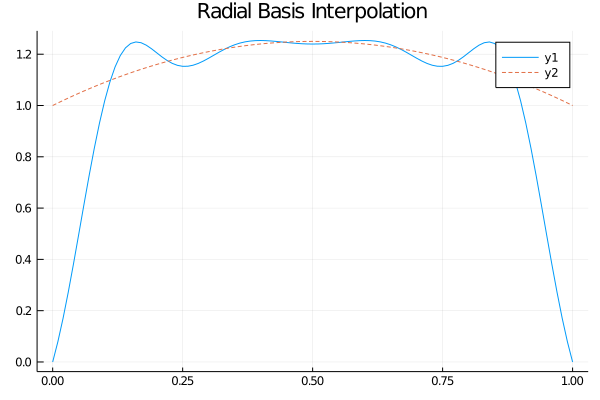

In [120]:
plot(X, rproj.(X), title="Radial Basis Interpolation")
plot!(X, F.(X), ls=:dash)

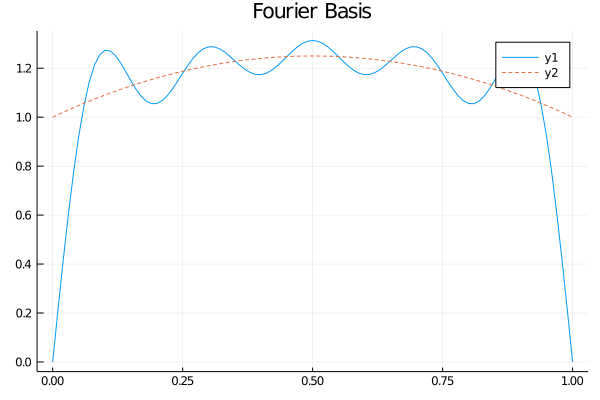

In [119]:
plot(X, fproj.(X), title="Fourier Basis")
plot!(X, F.(X), ls=:dash)

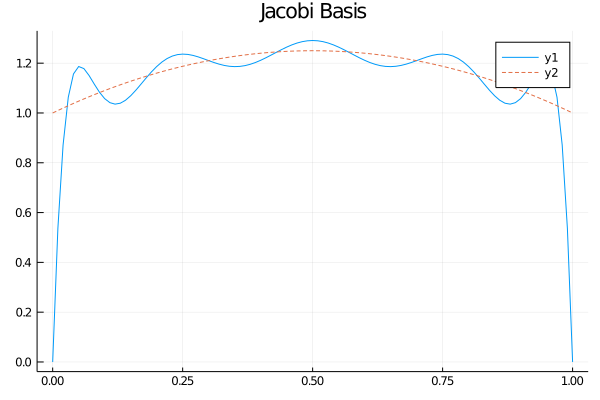

In [118]:
plot(X, jproj.(X), title="Jacobi Basis")
plot!(X, F.(X), ls=:dash)

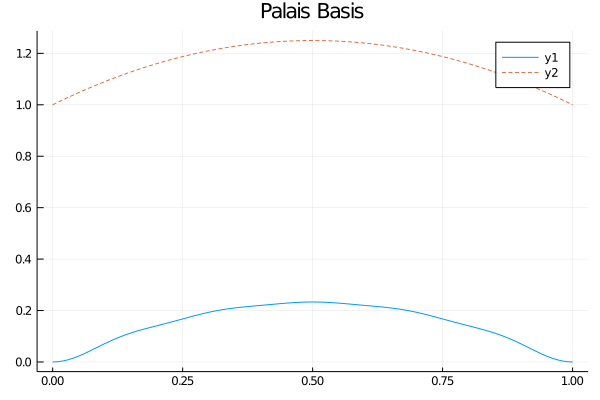

In [117]:
plot(X, gproj.(X), title="Palais Basis")
plot!(X, F.(X), ls=:dash)